In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Create Functions

In [3]:
def assign_score(num_indicators, df):
    # Check if num_indicators is 0
    if num_indicators == 0:
        return 0.0
    
    # Apply a logarithmic transformation to num_indicators
    transformed_num_indicators = np.log1p(num_indicators)  # Adding 1 to avoid log(0)
    
    # Find the minimum and maximum values in the transformed num_indicators column
    min_num = df['num_indicators'].apply(lambda x: np.log1p(x)).min()
    max_num = df['num_indicators'].apply(lambda x: np.log1p(x)).max()
    
    # Calculate the range of transformed num_indicators
    num_range = max_num - min_num
    
    # Define the number of intervals (score levels)
    num_intervals = 5  # You can adjust this as needed
    
    # Calculate the interval size
    interval_size = num_range / num_intervals
    
    # Calculate the score based on the interval
    score = min(5.0, max(1.0, 1.0 + (transformed_num_indicators - min_num) / interval_size))
    
    # Round the score to two decimal places
    rounded_score = round(score, 2)
    
    return rounded_score
def assign_scores_for_recency(dataframe, column_name):
    # Calculate scores based on adjusted recency criteria
    year_scores = dataframe[column_name].apply(lambda x: 
        0 if pd.isna(x) else
        1 if x <= 2000 else
        2 if x <= 2006 else
        3 if x <= 2012 else
        4 if x <= 2018 else  # Adjusted criteria: Change to 2017 for "Recent"
        5                  # Adjusted criteria: Datasets from 2018 and above are "Very Recent"
    )

    return year_scores

def calculate_final_score(df, col):
    # Equal weight for each of the three specific columns
    weight_indic_score = 3/10
    weight_year_score = 3/10
    weight_machine_read = 3/10
    
    # Weight for security_warning
    weight_security_warning = 1/10
    
    # Calculate the final_score
    final_score = (
        (df['indic_score'] * weight_indic_score) +
        (df['year_score'] * weight_year_score) +
        (df['machine_read'] * 5 * weight_machine_read) +
        (df[col] * 5 * weight_security_warning)
    )
    
    return final_score

    

## Import Data

In [3]:
df_org = pd.read_excel(r'../../datasets/ade/open_data_sources.xlsx', sheet_name='organisations')
df_ngos = pd.read_excel(r'../../datasets/ade/open_data_sources.xlsx', sheet_name='ngos')
df_gov = pd.read_excel(r'../../datasets/ade/open_data_sources.xlsx', sheet_name='government_sources')
df_gov.drop(columns=['comments'],inplace=True, axis=1)
df_org.rename(columns={'num_datasets' : 'num_indicators'}, inplace=True)

### Assign Scores

In [5]:
# df_org['year_score'] = assign_scores_for_recency(df_org, 'recency')
df_ngos['year_score'] = assign_scores_for_recency(df_org, 'recency')
df_org['year_score'] = assign_scores_for_recency(df_org, 'recency')
df_gov['year_score'] = assign_scores_for_recency(df_gov, 'recency')


In [6]:
df_ngos['indic_score'] = df_ngos['num_indicators'].apply(lambda x: assign_score(x, df_ngos))
df_org['indic_score'] = df_org['num_indicators'].apply(lambda x: assign_score(x, df_org))
df_gov['indic_score'] = df_gov['num_indicators'].apply(lambda x: assign_score(x, df_gov))


In [7]:
df_ngos['final_score'] = df_ngos.apply(lambda x: (1/3* x['indic_score'] )+ (1/3 * x['year_score'] )+ (1/3 * x['machine_read'] * 5), axis = 1)
df_ngos

,source,num_indicators,machine_read,recency,link,comments,full form,year_score,indic_score,final_score
0,open_africa,124,1,2020,https://africaopendata.org/dataset?q=tourism,NaN,Open Africa,5,5.0,5.000000
1,africa_geoportal,3,1,2023,https://www.africageoportal.com/explore?collec...,"82,148 data points, data is spatial",Africa GeoPortal,5,1.0,3.666667


In [8]:
df_org

,source,num_indicators,machine_read,recency,link,open_access_stat,full form,open_access_needed,year_score,indic_score
0,unwto,41,1,2020,NaN,0,UNWTO,1,5,3.73
1,world_bank,10,1,2020,https://datacatalog.worldbank.org/search/datas...,0,World Bank,1,5,2.53
2,afdb,1,0,2018,https://www.afdb.org/en/documents/africa-touri...,0,African Development Bank,1,4,1.00
3,statista,522,1,2022,NaN,1,Statista,0,5,5.00


In [9]:
df_org['final_score'] = calculate_final_score(df_org, 'open_access_needed')
df_org

,source,num_indicators,machine_read,recency,link,open_access_stat,full form,open_access_needed,year_score,indic_score,final_score
0,unwto,41,1,2020,NaN,0,UNWTO,1,5,3.73,4.619
1,world_bank,10,1,2020,https://datacatalog.worldbank.org/search/datas...,0,World Bank,1,5,2.53,4.259
2,afdb,1,0,2018,https://www.afdb.org/en/documents/africa-touri...,0,African Development Bank,1,4,1.00,2.000
3,statista,522,1,2022,NaN,1,Statista,0,5,5.00,4.500


In [30]:
df_gov['final_score'].median()

3.02

In [10]:
df_gov['final_score'] = calculate_final_score(df_gov, 'security_warning')
df_gov.sort_values(ascending=False, by=['final_score'])

,country,region,iso3_code,link,num_indicators,machine_read,recency,odfa_star,security_warning,security_,indicators,years,year_score,indic_score,final_score
3,Mauritius,Eastern Africa,MUS,https://statsmauritius.govmu.org/Pages/Statist...,25,1,2023.0,0,1,0,"Passenger traffic by sex,Passenger traffic bet...",NaN,5,5.00,5.000
6,Tanzania,Eastern Africa,TZA,https://www.nbs.go.tz/index.php/en/,27,1,2023.0,1,1,0,"international arrivals, international arrivals...",NaN,5,5.00,5.000
7,Cabo Verde,Western Africa,CPV,https://ine.cv/estatisticas-por-tema/,37,1,2022.0,0,1,0,"EVOLUÇÃO DO NUMERO DE ESTABELECIMENTOS, CAPACI...",NaN,5,5.00,5.000
11,Cote d'Ivoire,Western Africa,CIV,https://cotedivoire.opendataforafrica.org/okcy...,23,1,2021.0,1,1,0,"flow at the airport, roadway flow, rail track ...",NaN,5,5.00,5.000
8,Kenya,Eastern Africa,KEN,https://www.knbs.or.ke/download/tourism-sector/,14,1,2022.0,0,1,0,Number of International Visitor Arrivals by Pu...,NaN,5,4.44,4.832
22,Chad,Central Africa,TCD,https://chad.opendataforafrica.org/vmxfqic/tou...,11,1,2019.0,1,1,0,total international arrivals broken by prupose...,NaN,5,4.16,4.748
5,Togo,Western Africa,TGO,https://togo.opendataforafrica.org/data/?lang=...,9,1,2023.0,1,1,0,"Arrivée des touristes par zone de résidence, A...",NaN,5,3.93,4.679
20,Tunisia,Northern Africa,TUN,http://www.ins.tn/en/statistiques/129,8,1,2023.0,0,1,0,"Mouvement des voyageurs, ENTREES DES VOYAGEURS...",NaN,5,3.79,4.637
10,Mozambique,Eastern Africa,MOZ,https://mozambique.opendataforafrica.org/xsimh...,7,1,2022.0,1,1,0,"Number of hotels,number of hostels, room renta...",NaN,5,3.64,4.592
14,Burkina Faso,Western Africa,BFA,http://www.insd.bf/,5,1,2023.0,1,1,0,Evolution des nuitées au Burkina Faso selon la...,NaN,5,3.28,4.484


## Save Results

In [13]:
with pd.ExcelWriter(r'../../datasets/ade/results.xlsx') as writer:
    df_gov.to_excel(writer, sheet_name="government_sources")  
    df_ngos.to_excel(writer, sheet_name="ngos")  
    df_org.to_excel(writer, sheet_name="organisations")  

In [3]:
df_org_results = pd.read_excel(r'../../datasets/ade/results.xlsx', sheet_name='organisations')
df_ngos_results = pd.read_excel(r'../../datasets/ade/results.xlsx', sheet_name='ngos')
df_gov_results = pd.read_excel(r'../../datasets/ade/results.xlsx', sheet_name='government_sources')

### Plots

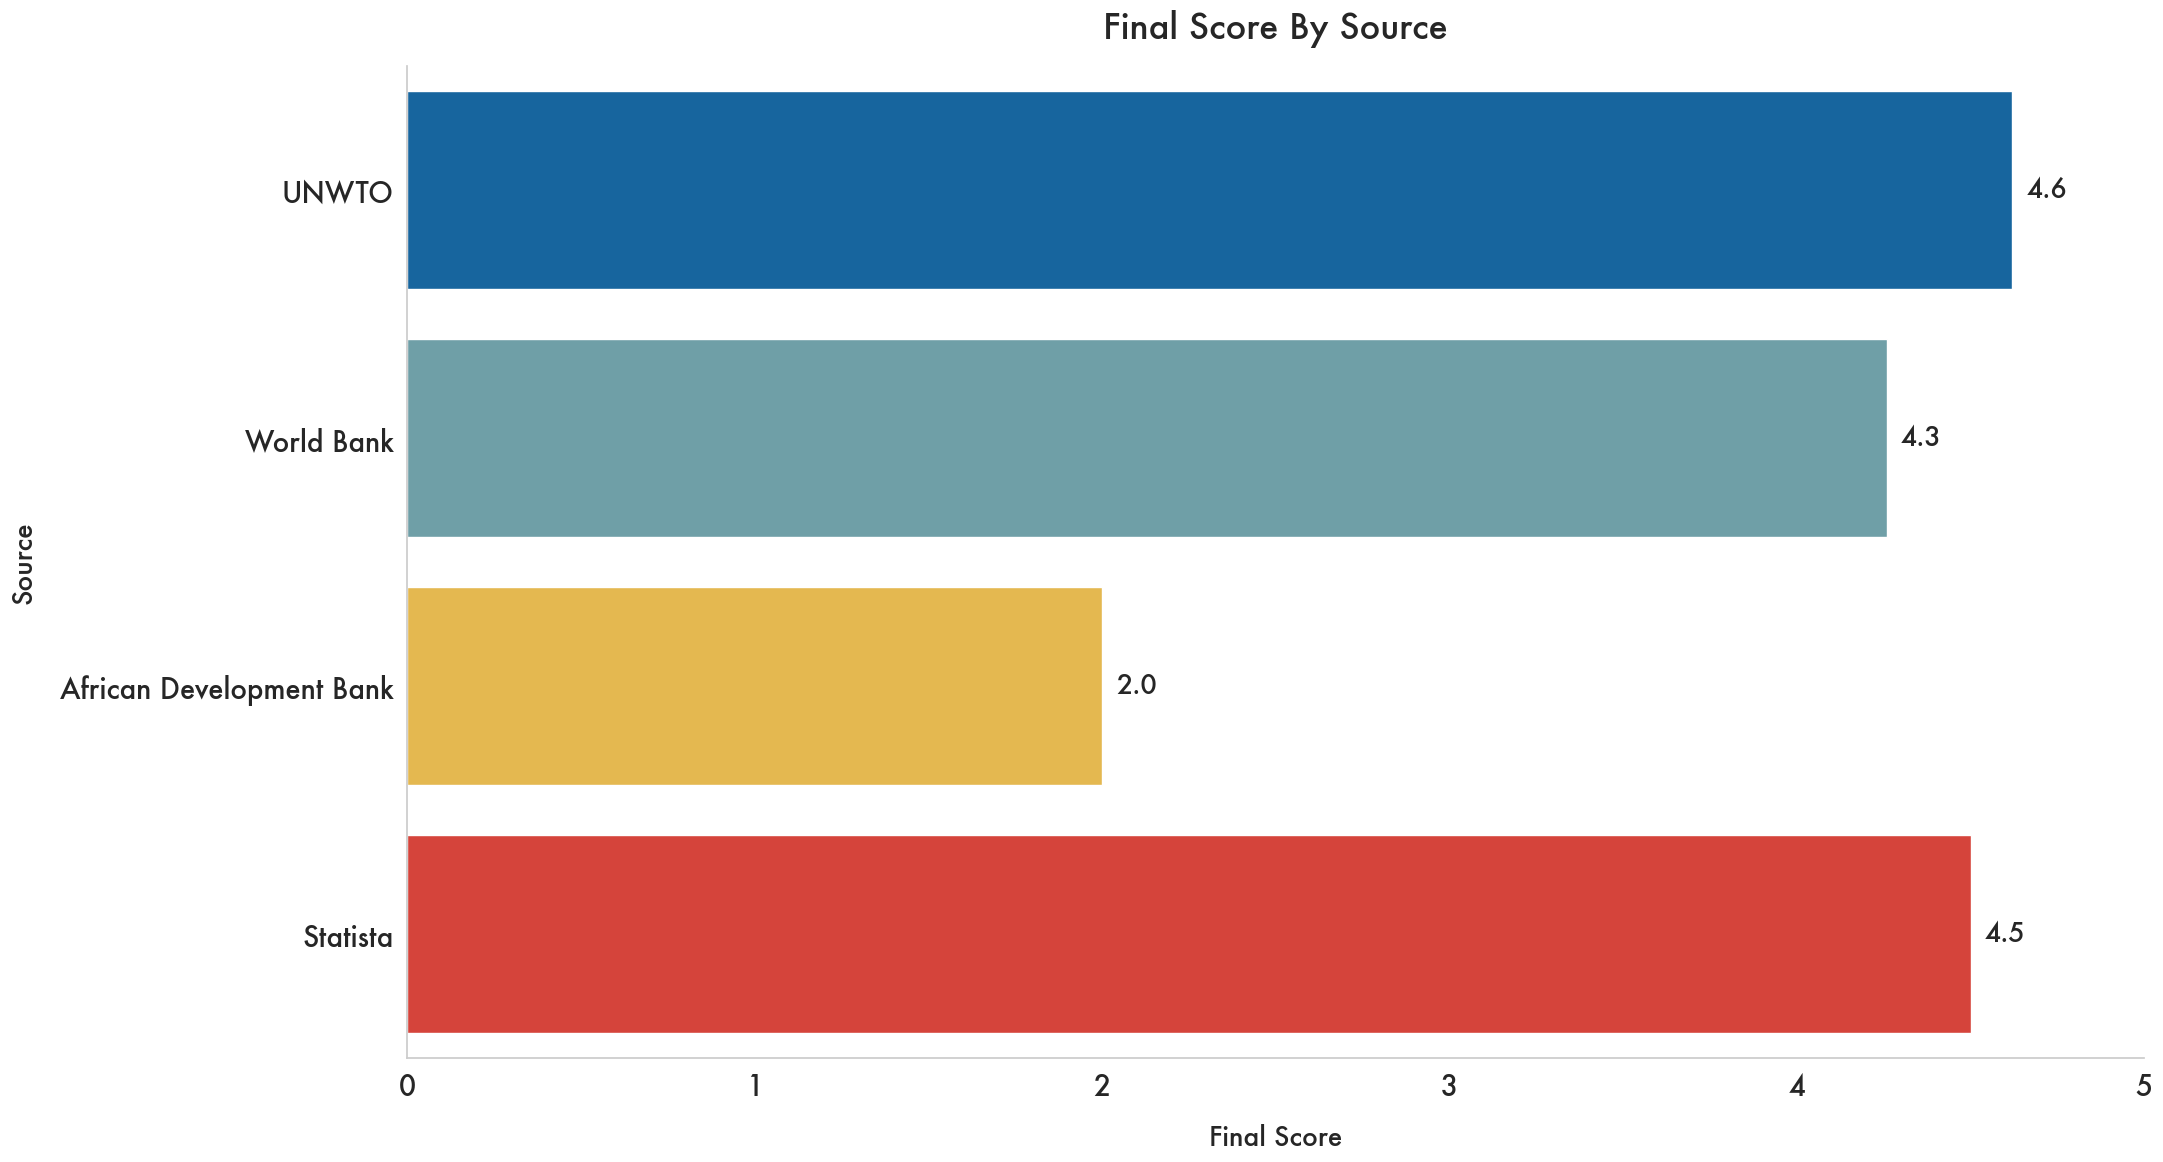

In [10]:

# Set the seaborn style and color palette
sns.set(style="whitegrid")
colors = ["#0069b4", "#66a6b0", "#fdc237", "#ee2e22", "#a21352"]
plt.rcParams['font.family'] = 'Futura'
plt.rcParams['font.size'] = 19
# Create a horizontal bar plot using seaborn
plt.figure(figsize=(22, 12))
barplot = sns.barplot(x='final_score', y='full form', data=df_org_results, palette=colors)

# Title with increased spacing
plt.title('Final Score By Source', fontsize=25, pad=20, fontdict={'weight': 'bold'})

# Increase spacing for x-axis and y-axis labels
plt.xlabel('Final Score', fontsize=19, labelpad=15)
plt.ylabel('Source', fontsize=19, labelpad=15)
plt.grid(False)
sns.despine(right=True, top=True)
# Increase spacing for x-axis and y-axis ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display the values on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.1f}',
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha='center', va='center',
                     xytext=(25, 0),  # 15 points horizontal offset
                     textcoords='offset points')

# Set the x-axis limits to start from 0 and end at 4
plt.xlim(0, 5)

# Add source text
# plt.figtext(0, 0.01, "Source: WiTH Africa, 2023", ha="left", fontsize=12, color='lightgray')

# Save the plot
#plt.savefig('/Users/dhruvpandit/Mirror/Documents/With Africa/ADE Report/mean_valh.png', dpi=400)

plt.tight_layout()
plt.show()


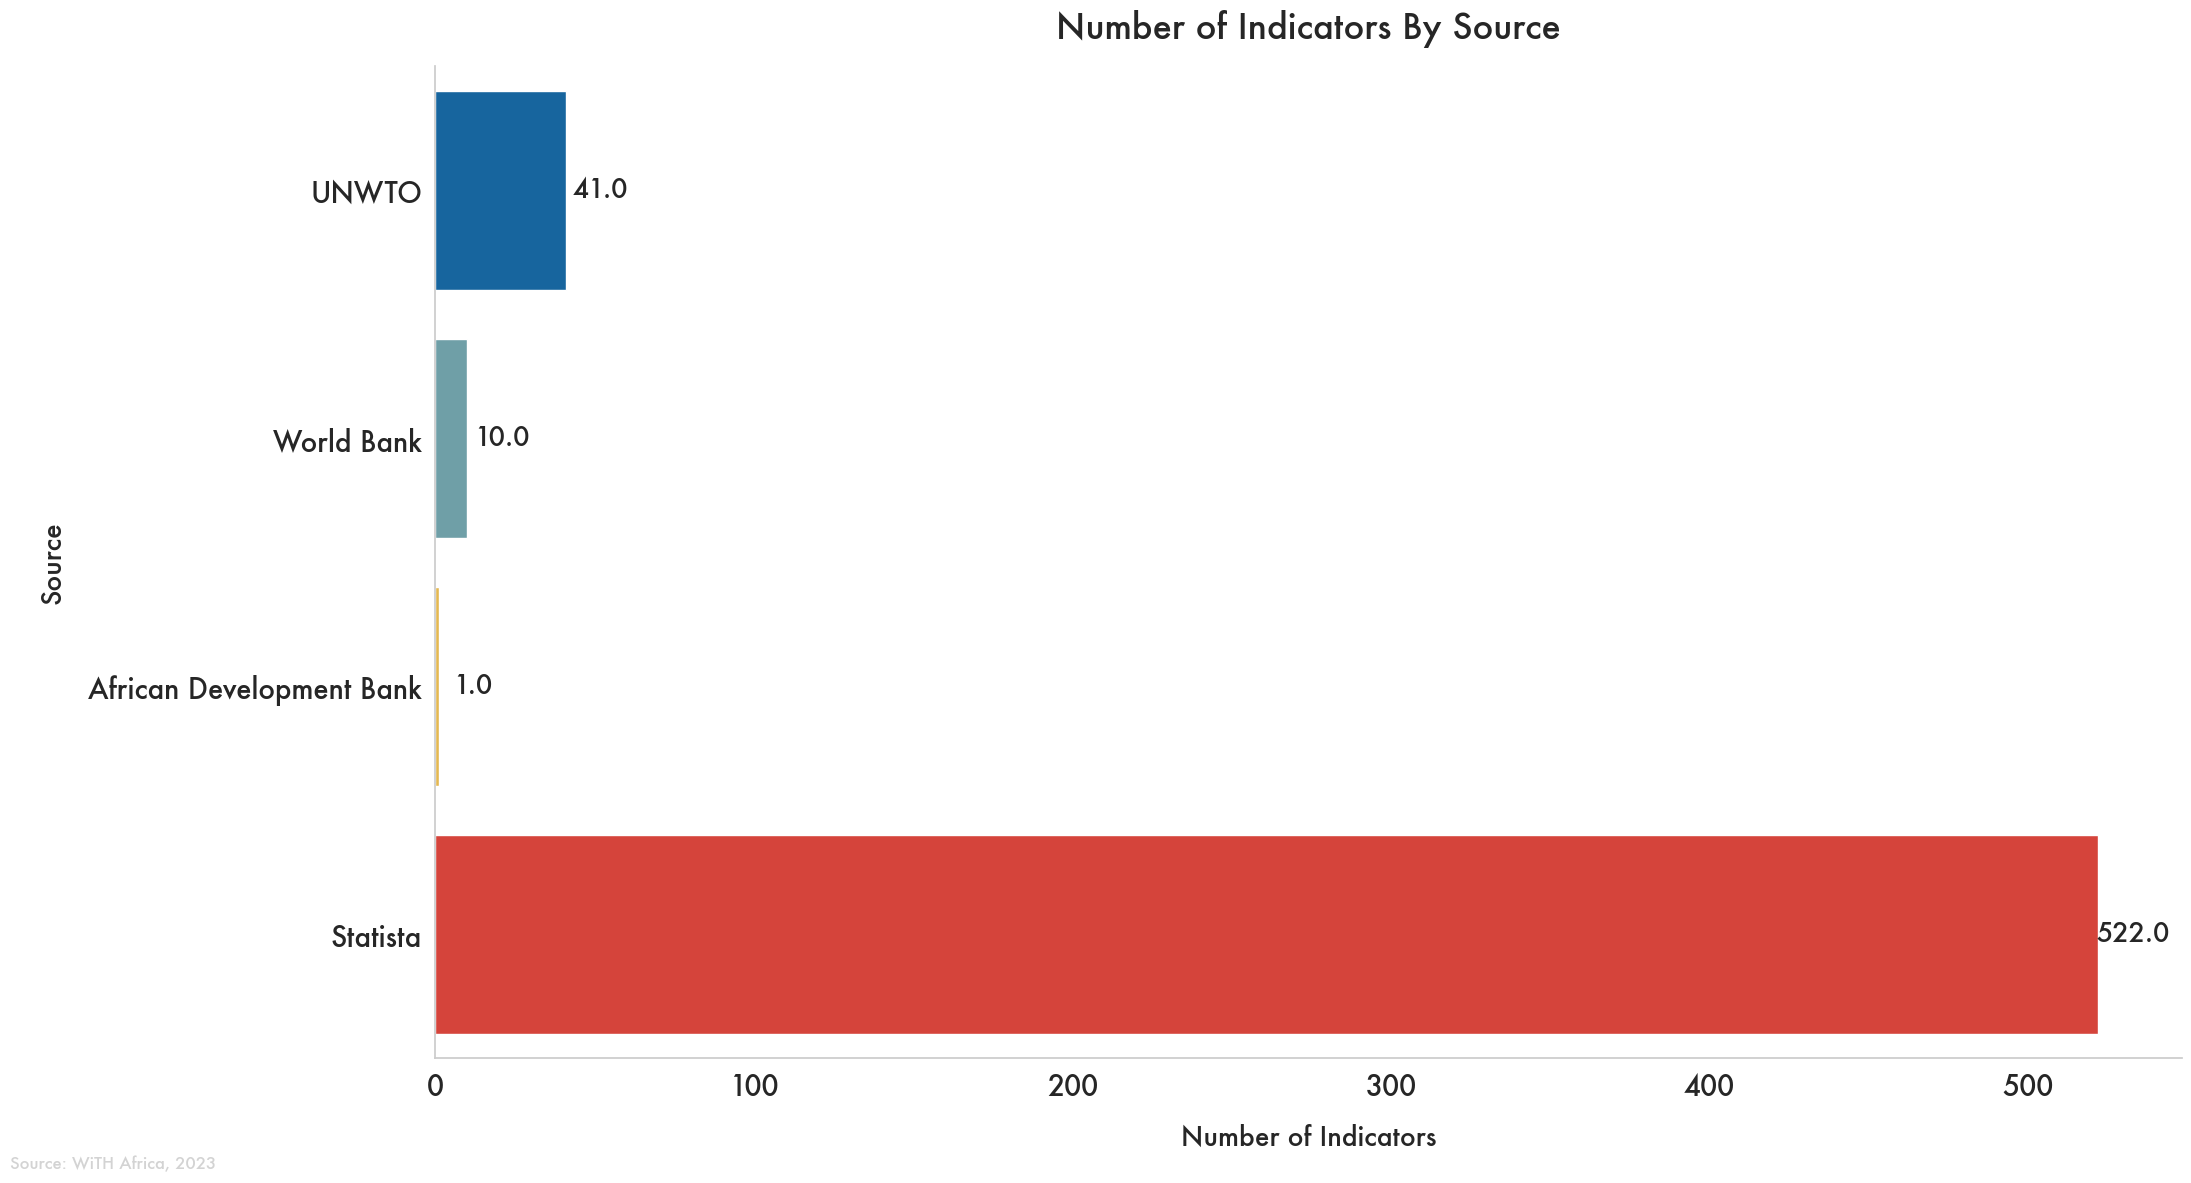

In [9]:
# Set the seaborn style and color palette
sns.set(style="whitegrid")
colors = ["#0069b4", "#66a6b0", "#fdc237", "#ee2e22", "#a21352"]
plt.rcParams['font.family'] = 'Futura'
plt.rcParams['font.size'] = 19
# Create a horizontal bar plot using seaborn
plt.figure(figsize=(22, 12))
barplot = sns.barplot(x='num_indicators', y='full form', data=df_org_results, palette=colors)

# Title with increased spacing
plt.title('Number of Indicators By Source', fontsize=25, pad=20, fontdict={'weight': 'bold'})

# Increase spacing for x-axis and y-axis labels
plt.xlabel('Number of Indicators', fontsize=19, labelpad=15)
plt.ylabel('Source', fontsize=19, labelpad=15)
plt.grid(False)
sns.despine(right=True, top=True)
# Increase spacing for x-axis and y-axis ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display the values on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.1f}',
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha='center', va='center',
                     xytext=(25, 0),  # 15 points horizontal offset
                     textcoords='offset points')

# Set the x-axis limits to start from 0 and end at 4
#plt.xlim(0, 5)

# Add source text
# plt.figtext(0, 0.01, "Source: WiTH Africa, 2023", ha="left", fontsize=12, color='lightgray')

# Save the plot
#plt.savefig('/Users/dhruvpandit/Mirror/Documents/With Africa/ADE Report/mean_valh.png', dpi=400)

plt.tight_layout()
plt.show()


In [25]:
df_gov_results.sort_values('num_indicators', ascending=False)

,Unnamed: 0,country,region,iso3_code,link,num_indicators,machine_read,recency,odfa_star,security_warning,security_,indicators,years,year_score,indic_score,final_score
26,26,Uganda,Eastern Africa,UGA,https://www.tourism.go.ug/statistics,50,0,2016.0,0,1,0,"Tourist Arrivals from the EAC Partner States, ...",NaN,4,5.00,3.200
7,7,Cabo Verde,Western Africa,CPV,https://ine.cv/estatisticas-por-tema/,37,1,2022.0,0,1,0,"EVOLUÇÃO DO NUMERO DE ESTABELECIMENTOS, CAPACI...",NaN,5,5.00,5.000
0,0,Eswatini (former Swaziland),Southern Africa,SWZ,https://www.thekingdomofeswatini.com/eta-resou...,35,0,2023.0,0,1,0,"rooms available, room nights sold, number of b...","2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022...",5,5.00,3.500
29,29,Ghana,Western Africa,GHA,https://www.statsghana.gov.gh/nationalaccount_...,31,0,2014.0,0,1,0,"International tourist arrivals and receipts, i...",NaN,4,5.00,3.200
19,19,Sierra Leone,Western Africa,SLE,http://www.statistics.sl/images/2020/Documents...,28,0,2020.0,0,1,0,"Facilities check-in-time by District, Faciliti...",NaN,5,5.00,3.500
6,6,Tanzania,Eastern Africa,TZA,https://www.nbs.go.tz/index.php/en/,27,1,2023.0,1,1,0,"international arrivals, international arrivals...",NaN,5,5.00,5.000
3,3,Mauritius,Eastern Africa,MUS,https://statsmauritius.govmu.org/Pages/Statist...,25,1,2023.0,0,1,0,"Passenger traffic by sex,Passenger traffic bet...",NaN,5,5.00,5.000
11,11,Cote d'Ivoire,Western Africa,CIV,https://cotedivoire.opendataforafrica.org/okcy...,23,1,2021.0,1,1,0,"flow at the airport, roadway flow, rail track ...",NaN,5,5.00,5.000
12,12,Botswana,Southern Africa,BWA,https://www.statsbots.org.bw/sites/default/fil...,23,0,2021.0,0,1,0,Number of Tourists by Country of Residence and...,NaN,5,5.00,3.500
31,31,Senegal,Western Africa,SEN,https://www.ansd.sn/Indicateur/seschapitre-tou...,19,1,2012.0,1,1,0,ENTRY OF TOURISTS BY NATIONALITY AT DAKAR AIRP...,NaN,3,4.81,4.343


In [27]:
df_org_results['group'] = 'Institutions'
df_gov_results['group'] = 'Government'
df_ngos_results['group'] = 'NGOS'
df_gov_results['source'] =df_gov_results['country']
df_gov_results['full form'] =df_gov_results['country']


columns = ['num_indicators', 'source', 'full form', 'recency', 'final_score', 'group']


In [28]:
import plotly.io as pio

df_combined = pd.concat([df_gov_results[columns], df_ngos_results[columns], df_org_results[columns]], join='inner')

# Filter out rows where num_indicators is zero or missing
df_combined = df_combined[df_combined['num_indicators'] > 0]

fig = px.treemap(df_combined, 
                 path=[px.Constant("All Sources"), 'group', 'full form'],
                 values='num_indicators',
                 color='recency',
                 color_continuous_scale='RdBu',
                 hover_data=['num_indicators', 'recency']
                )
fig.update_layout(title_text="Breakdown of Number of Indicators for Each Source, Colored for Recency", title_x=0.5)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),   font=dict(family="Futura, sans-serif", size=12, color="black"),
    coloraxis_colorbar=dict(title="Recency"))
#pio.write_image(fig, '/Users/dhruvpandit/Mirror/Documents/With Africa/Open Data Paper/treemap.png', width=1920, height=1080)
#fig.write_html('/Users/dhruvpandit/Mirror/Documents/With Africa/Open Data Paper/treemap.html')
fig.show()


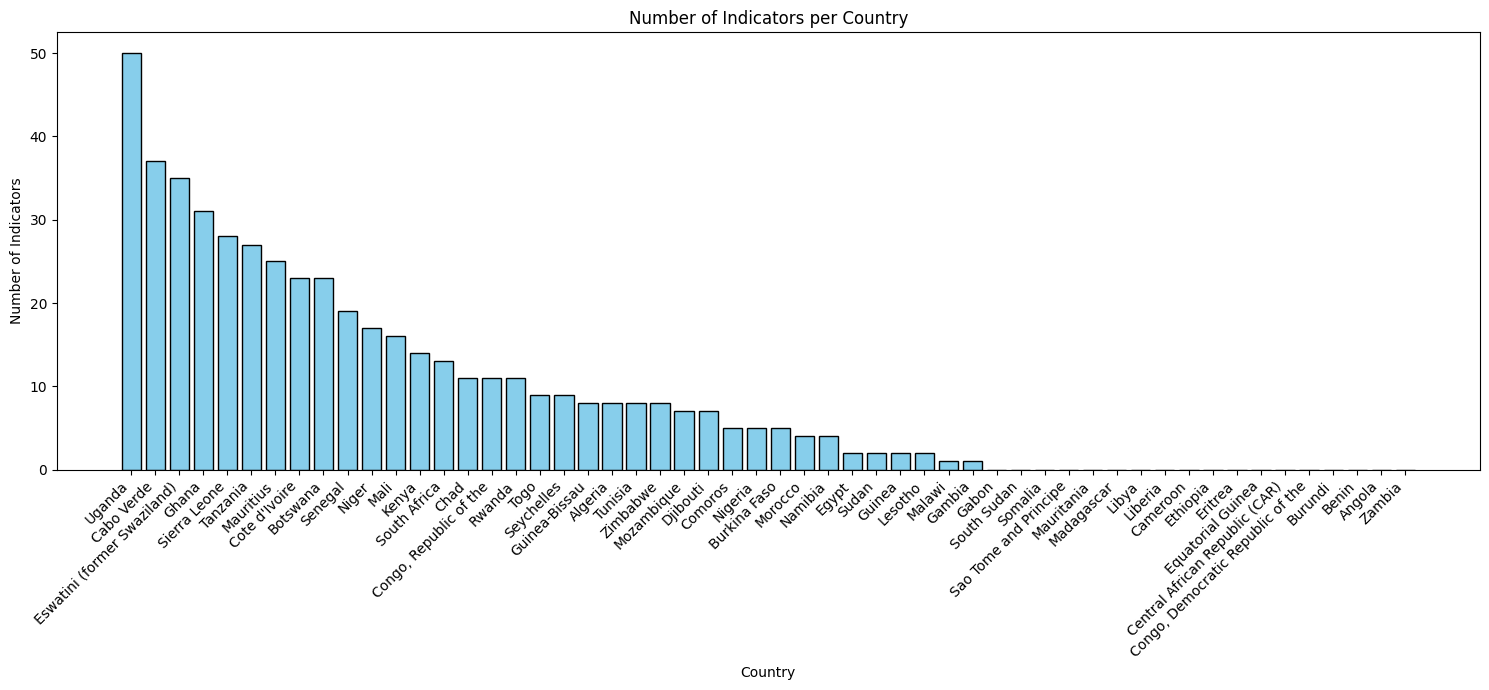

In [23]:
# Attempting to plot using a different approach
fig, ax = plt.subplots(figsize=(15, 7))

# Sorting data by 'num_indicators'
df_sorted = df_gov.sort_values(by='num_indicators', ascending=False)

# Plotting the bar chart
ax.bar(df_sorted['country'], df_sorted['num_indicators'], color='skyblue', edgecolor='black')
ax.set_title('Number of Indicators per Country')
ax.set_ylabel('Number of Indicators')
ax.set_xlabel('Country')
ax.set_xticks(df_sorted['country'])
ax.set_xticklabels(df_sorted['country'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [16]:
from langdetect import detect, LangDetectException
from googletrans import Translator
from deep_translator import GoogleTranslator
translator = Translator()

def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

def translate_to_english(text):
    try:
        return translator.translate(text, dest='en').text
    except Exception as e:
        print(f"Error in translation: {e}")
        return text

def clean_and_capitalize(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return text  # Return as is if not a string

    # Splitting the text by commas and stripping whitespace
    indicators = [indicator.strip() for indicator in text.split(',')]
    indic = []
    for each in indicators:
        indic.append(GoogleTranslator(source='auto', target='english').translate(each))
    # Capitalizing each indicator
    capitalized_indicators = [indicator.capitalize() for indicator in indic]

    # Joining the indicators back into a single string
    return ', '.join(capitalized_indicators)

# Now df['indicators_column'] will have the cleaned, translated, and capitalized indicators

# Assuming df is your DataFrame and 'indicators_column' is your column name
df_gov_results['indicators_clean'] = df_gov_results['indicators'].apply(clean_and_capitalize)



In [17]:
df_gov_results['indicators_clean']

0     Passenger traffic by sex, Passenger traffic be...
1     International arrivals, International arrivals...
2     Evolution of the number of establishments, Cap...
3     Flow at the airport, Roadway flow, Rail track ...
4     Number of international visitor arrivals by pu...
5     Total international arrivals broken by prupose...
6     Arrival of tourists by area of ​​residence, To...
7     Movement of travelers, Entry of travelers by n...
8     Number of hotels, Number of hostels, Room rent...
9     Evolution of overnight stays in burkina faso a...
10    Entry of tourists by nationality at dakar airp...
11    Arrivals by market and port of entry, Arrivals...
12    Number of tourists by group, Number of tourist...
13    Number of beds available, Number of bed-nights...
14    Number of foreign tourists, Toruism revenue in...
15    Average stay duration, Hotel occupancy, Number...
16    Rooms available, Room nights sold, Number of b...
17    Number of tourists by country of residence

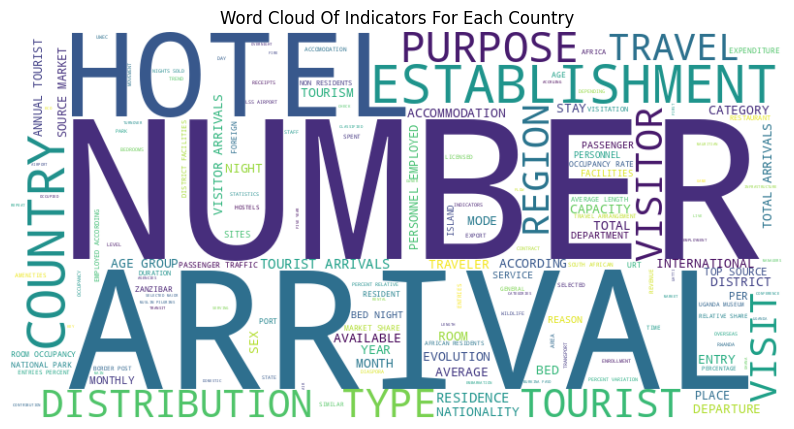

In [13]:
from wordcloud import WordCloud

# Transform the 'indicators' column to uppercase
df_gov_results['indicators_clean'] = df_gov_results['indicators_clean'].str.upper()

# Combine all the indicators into a single string
text = " ".join(indicator for indicator in df_gov_results['indicators_clean'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Of Indicators For Each Country')
plt.show()
